In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

from scipy.spatial import procrustes

In [4]:
dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/blockdiag_noisy"

dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
# respkl   = os.path.join("../dsc/results", dsc_fname + ".pkl")
# dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")

# if os.path.isfile(dscoutpkl):
#     dscout = pd.read_pickle(dscoutpkl)
# else:
#     print ("Could not find dscout from dscquery")

# refresh_pickle = True
# sim_module = "blockdiag_h2shared"
# target = [sim_module] + [f"{sim_module}.{prop}" for prop in ["p", "k", "h2", "h2_shared_frac", "aq", "a0"]]

condition = [""]
target = ["blockdiag", "blockdiag.nsample_minmax"]

print ("Reading from DSC database:")
print (f"    {db}")
print ("")

qp = dscQP(db, target, condition)
df = qp.output_table

df

Reading from DSC database:
    /gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/blockdiag_noisy/blockdiag_noisy.db



,DSC,blockdiag.output.file,blockdiag.nsample_minmax
0,1,blockdiag/blockdiag_1,"(100,400)"
1,1,blockdiag/blockdiag_2,"(1000,4000)"
2,1,blockdiag/blockdiag_3,"(10000,40000)"
3,2,blockdiag/blockdiag_4,"(100,400)"
4,2,blockdiag/blockdiag_5,"(1000,4000)"
5,2,blockdiag/blockdiag_6,"(10000,40000)"
6,3,blockdiag/blockdiag_7,"(100,400)"
7,3,blockdiag/blockdiag_8,"(1000,4000)"
8,3,blockdiag/blockdiag_9,"(10000,40000)"
9,4,blockdiag/blockdiag_10,"(100,400)"


In [13]:
def do_standardize(Z, axis = 0, center = True, scale = True):
    '''
    Standardize (divide by standard deviation)
    and/or center (subtract mean) of a given numpy array Z

    axis: the direction along which the std / mean is aggregated.
        In other words, this axis is collapsed. For example,
        axis = 0, means the rows will aggregated (collapsed).
        In the output, the mean will be zero and std will be 1
        along the remaining axes.
        For a 2D array (matrix), use axis = 0 for column standardization
        (with mean = 0 and std = 1 along the columns, axis = 1).
        Simularly, use axis = 1 for row standardization
        (with mean = 0 and std = 1 along the rows, axis = 0).

    center: whether or not to subtract mean.

    scale: whether or not to divide by std.
    '''
    if scale:
        Znew = Z / np.std(Z, axis = axis, keepdims = True)
    else:
        Znew = Z.copy()

    if center:
        Znew = Znew - np.mean(Znew, axis = axis, keepdims = True)

    return Znew

def get_principal_components(X):
    X_cent = do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    loadings = U @ np.diag(S)
    factors  = Vt.T
    return U, S, loadings, factors

In [27]:
sim_seqs = np.arange(1,31)
nnm_loadings = dict()
nnm_factors = dict()
for i in sim_seqs:
    nnm_file = os.path.join(dsc_output, f"truncated_svd/blockdiag_{i}_nnm_1_truncated_svd_1.pkl")
    with open(nnm_file, "rb") as mfile:
        nnm_res = pickle.load(mfile)
        nnm_loadings[i] = nnm_res['L_est']
        nnm_factors[i] = nnm_res['F_est']

In [28]:
factorgo_loadings = dict()
factorgo_factors = dict()
for i in sim_seqs:
    factorgo_file = os.path.join(dsc_output, f"factorgo/blockdiag_{i}_identical_1_factorgo_1.pkl")
    with open(factorgo_file, "rb") as mfile:
        factorgo_res = pickle.load(mfile)
        factorgo_loadings[i] = factorgo_res['L_est']
        factorgo_factors[i] = factorgo_res['F_est']

In [29]:
nnm_sparse_loadings = dict()
nnm_sparse_factors = dict()
for i in sim_seqs:
    nnm_sparse_file = os.path.join(dsc_output, f"truncated_svd/blockdiag_{i}_nnm_sparse_1_truncated_svd_1.pkl")
    with open(nnm_sparse_file, "rb") as mfile:
        nnm_sparse_res = pickle.load(mfile)
        nnm_sparse_loadings[i] = nnm_sparse_res['L_est']
        nnm_sparse_factors[i] = nnm_sparse_res['F_est']

In [30]:
rpca_loadings = dict()
rpca_factors = dict()
for i in sim_seqs:
    rpca_file = os.path.join(dsc_output, f"truncated_svd/blockdiag_{i}_rpca_1_truncated_svd_1.pkl")
    with open(rpca_file, "rb") as mfile:
        rpca_res = pickle.load(mfile)
        rpca_loadings[i] = rpca_res['L_est']
        rpca_factors[i] = rpca_res['F_est']

In [37]:
def get_rmse(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    n = np.sum(mask)
    mse = np.nansum(np.square((original - recovered) * mask)) / n
    return np.sqrt(mse)

nnm_Lrmse = dict()
rpca_Lrmse = dict()
factorgo_Lrmse = dict()
for i in sim_seqs[1:]:
    nnm_Lrmse[i] = get_rmse(nnm_loadings[1], nnm_loadings[i])
    rpca_Lrmse[i] = get_rmse(rpca_loadings[1], rpca_loadings[i])
    factorgo_Lrmse[i] = get_rmse(factorgo_loadings[1], factorgo_loadings[i])
    
nnm_Frmse = dict()
rpca_Frmse = dict()
factorgo_Frmse = dict()
for i in sim_seqs[1:]:
    nnm_Frmse[i] = get_rmse(nnm_factors[1], nnm_factors[i])
    rpca_Frmse[i] = get_rmse(rpca_factors[1], rpca_factors[i])
    factorgo_Frmse[i] = get_rmse(factorgo_factors[1], factorgo_factors[i])

In [39]:
nnm_Lrmse.values()

dict_values([0.002613611906530193, 0.014869444175591922, 5.136540978551185e-05, 0.002593089519811464, 0.014524431458416904, 0.00010697214212440729, 0.002698771343073363, 0.01464740589580072, 0.0001087705706914326, 0.0026568928249797574, 0.014913148520209866, 9.719239393680173e-05, 0.0027736265386995216, 0.01457586543162729, 9.782525570448254e-05, 0.002697016364331873, 0.014852724693654396, 8.547010725707466e-05, 0.002734885412789873, 0.014851612223808725, 0.00010779878318374331, 0.002733603098979453, 0.01476628724683979, 6.655724901317407e-05, 0.0026806824141063054, 0.014281314021014705, 9.997507124991273e-05, 0.0027044574348968394, 0.014538736158104542])

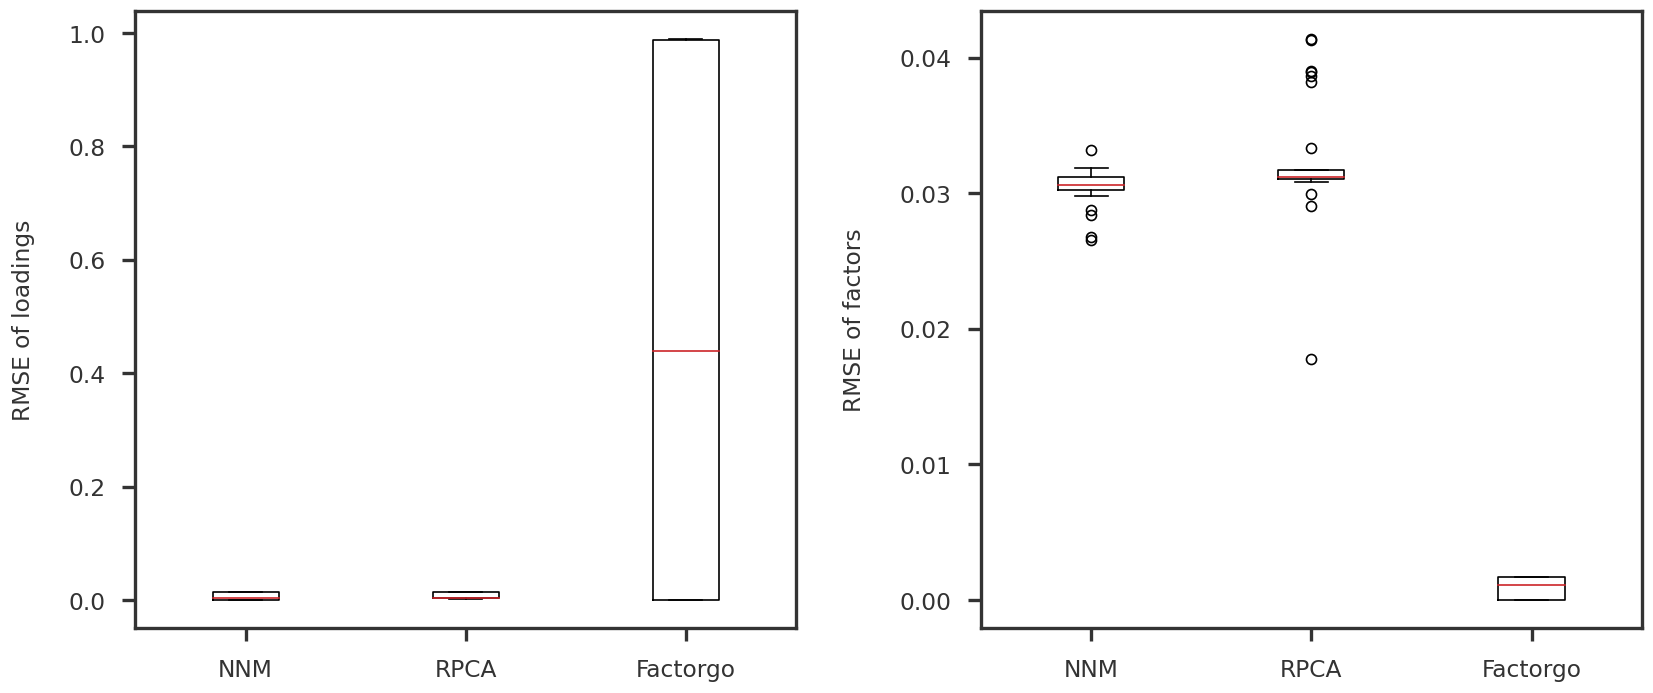

In [46]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Ldata = [list(nnm_Lrmse.values()), list(rpca_Lrmse.values()), list(factorgo_Lrmse.values())]
Fdata = [list(nnm_Frmse.values()), list(rpca_Frmse.values()), list(factorgo_Frmse.values())]
labels = ["NNM", "RPCA", "Factorgo"]

ax1.boxplot(Ldata)
ax2.boxplot(Fdata)
ax1.set_xticklabels(labels)
ax2.set_xticklabels(labels)
ax1.set_ylabel("RMSE of loadings")
ax2.set_ylabel("RMSE of factors")

plt.tight_layout(w_pad = 2.0)
plt.show()

### Check for correlation to avoid identifiability